<a href="https://www.kaggle.com/code/aayusmaanjain/object-detection-for-self-driving-cars?scriptVersionId=110090829" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch 
import os 
import numpy as np 
import cv2 
import pandas as pd 
import matplotlib.pyplot as plt 
from glob import glob
import yaml

# Initializing constants

In [2]:
IMG_HEIGHT = 720
IMG_WIDTH = 1280
# Source: https://github.com/ucbdrive/bdd100k/blob/master/doc/format.md#bdd100k-details
labels = [
    "bike",
    "bus",
    "car",
    "motor",
    "person",
    "rider",
    "traffic light",
    "traffic sign",
    "train",
    "truck"
]

TRAIN_PATH = '../input/bdd100k-for-self-driving-cars/Data/train'
VAL_PATH = '../input/bdd100k-for-self-driving-cars/Data/val'
MODEL_PATH = '../input/bdd100k-for-self-driving-cars/Data/best.pt'
INFERENCE_PATH = '../input/bdd-dataset-for-self-driving-car/inference_vid.mp4'
STEERING_WHEEL_PATH = '../input/bdd100k-for-self-driving-cars/Data/steering_wheel_image.jpg'

# Seeing examples from data

In [3]:
train_images = glob(f'{TRAIN_PATH}/*.jpg')
val_images = glob(f'{VAL_PATH}/*.jpg')
n_samples = 5
train_sample = np.random.choice(train_images, size=n_samples)
val_sample = np.random.choice(val_images, size=n_samples)

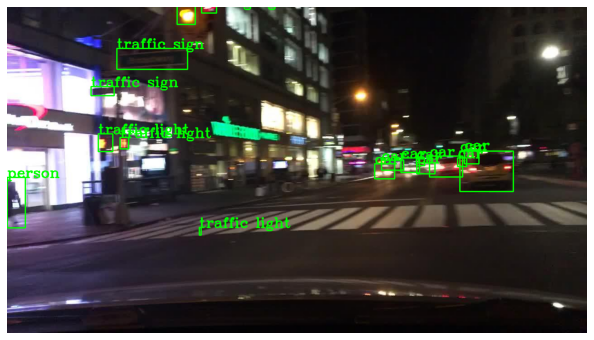

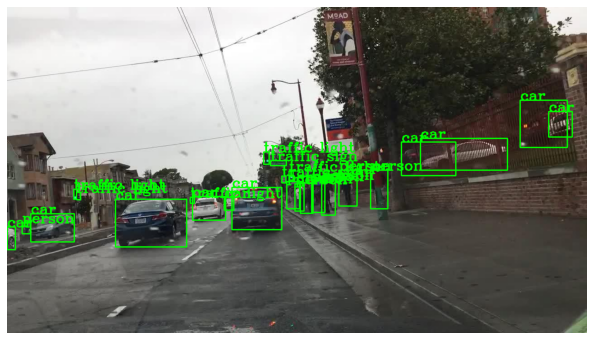

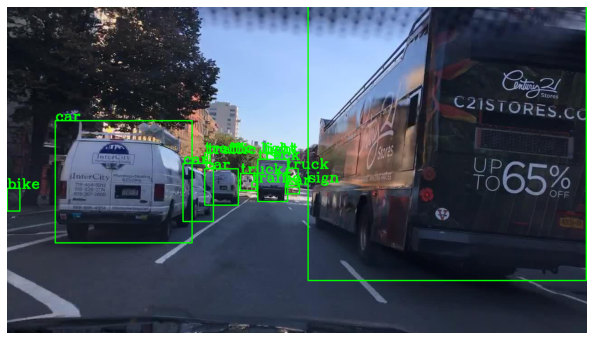

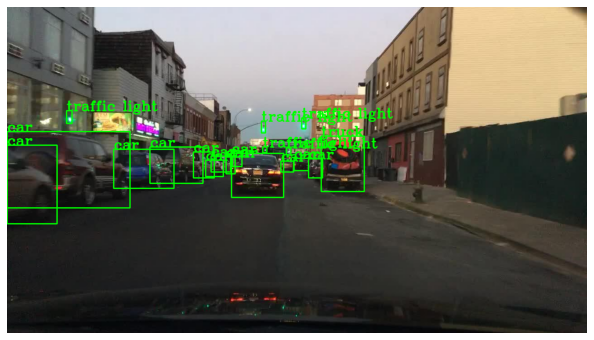

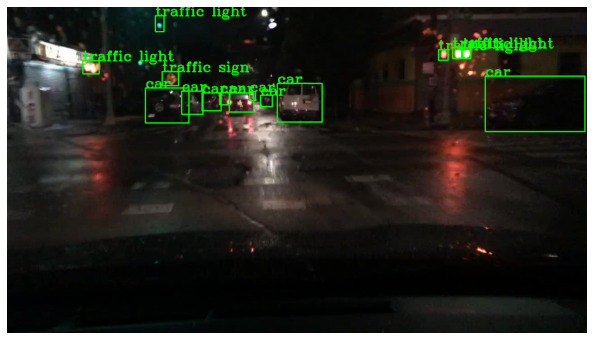

In [4]:
for i in range(n_samples):
    _, ax = plt.subplots(figsize=(16,6))
    train_path = train_sample[i]
    img_id = train_path.split(os.path.sep)[-1].split('.')[0]
    label_file = os.path.join(TRAIN_PATH, f'{img_id}.txt')
    with open(label_file, 'r') as f:
        lines = f.readlines()
    img = cv2.imread(train_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for label in lines:
        splits = label.split()
        category = labels[int(splits[0])]
        x_center = float(splits[1]) * IMG_WIDTH
        y_center = float(splits[2]) * IMG_HEIGHT
        width = float(splits[3]) * IMG_WIDTH
        height = float(splits[4]) * IMG_HEIGHT

        pt1_x = x_center - width/2
        pt1_y = y_center - height/2
        pt2_x = x_center + width/2
        pt2_y = y_center + height/2

        pt1 = (int(pt1_x), int(pt1_y))
        pt2 = (int(pt2_x), int(pt2_y))

        img = cv2.rectangle(img, pt1=pt1, pt2=pt2, color=(0,255,0), thickness=2)
        img = cv2.putText(img, category, org=pt1, 
                          color=(0,255,0), fontFace = cv2.FONT_HERSHEY_COMPLEX, 
                          fontScale=1, thickness=2)


    ax.imshow(img)
    ax.axis('off')
    plt.show()

# Training YOLO model 


The code is commented, unccomment the code below to train a newer version of the model

In [5]:
# Creating data.yaml file 
data = {
    'train':os.path.abspath(TRAIN_PATH),
    'val':os.path.abspath(VAL_PATH), 
    'names':labels,
    'nc':len(labels)
}

with open('data.yaml', 'w+') as f: 
    yaml.safe_dump(data, f)

In [6]:
# Cloning the ultralytics yolov5 repository
! git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 14468, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 14468 (delta 7), reused 17 (delta 4), pack-reused 14446
Receiving objects: 100% (14468/14468), 13.46 MiB | 46.73 MiB/s, done.
Resolving deltas: 100% (9980/9980), done.


In [7]:
# Installing the dependencies required for YOLO
# ! pip install -r yolov5/requirements.txt

In [8]:
# ! wandb disabled

In [9]:
# Training the YOLO model 
# ! python ./yolov5/train.py --data ./data.yaml  --batch-size 8  --epochs 100 --weights yolov5/yolov5s.pt

In [10]:
model = torch.hub.load('yolov5', 'custom', path=MODEL_PATH, source='local')

YOLOv5 🚀 v6.2-226-gfde7758 Python-3.7.12 torch-1.11.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7037095 parameters, 0 gradients
Adding AutoShape... 


In [11]:
wheel = cv2.imread(STEERING_WHEEL_PATH)
wheel = cv2.cvtColor(wheel, cv2.COLOR_BGR2GRAY)
rows, cols = wheel.shape

In [12]:
val_images = glob(f'{VAL_PATH}/*.jpg')

In [13]:
sample_images = np.random.choice(val_images, size=5)

# Predicting the steering angle from images

Considerations taken while predicting the steering angle
* The car has power steering, and, in most cases, the power steering rotates for 1 and 3/4th rotations in either side which converted to degrees is 630 degrees in either side

* We have assumed that the dashcam is positioned in the center of the dashboard

# Positioning the car in a co ordinate system 

We have considered the image to be a 2-dimensional coordinate plane and the center of the obstacles are considered as points on that plane. 

To navigate the car, we take the centroid of all the obstacles which is a good indicator of most of the objects are located and we can then navigate the vehicle in the opposite direction

# Possible scenarios while navigating the car

* Centroid is on the left half of the screen – in this case, since most of the objects are in the left half, we take right
* Centroid is on the right half of the screen – in this case, since most of the objects are in the right half, we take left
* Centroid is in the middle – in this case, there are three possible cases: - there are objects on both sides and since there are objects on both sides, we cannot turn. Another case may be that the objects are in the extremes of both sides, in this case the middle of the road is free, and the car can go straight. Another possible scenario is that the objects are in the middle of the screen and since the objects are in the middle, the car should not turn as there might be vehicles behind it and should remain in the lane. 


# Framing the heuristic function

$$
h(x) = \frac{center - x}{center} \\
center = \frac{width}{2}
$$

In the first equation, if the object is in the left half, the value of h is positive which indicates that the vehicle should go right, likewise if the object is in the right half, the value of h is negative which indicates that the car should go left. If the object is in the center or close to center, the value of h is close to 0 which indicates that the car should continue straight. 

Mathematically, 

$$
\begin{cases} 
      0 \leq x \leq 1 (left) \\
      0 (middle) \\
      -1 \leq x \leq 0 (right)
\end{cases} 
$$

# Quadratic transformation on the heuristic

To solve this, we have transformed the heuristic into a quadratic equation. We have observed that if the object is at the left end or the right end, the car should continue straight (i.e. rotation=0) and if the object is at the center, in that case also, the rotation should be 0. So we have transformed the heuristic function into a quadratic equation whose roots are -1 (for extreme right end), 0 (for the center) and 1 (for the left end). 


Now we can express the rotation angle as 

$$
rot = (h-1)(h)(h+1) \\
rot = rot * 630
$$

In the graph of the equation, we observe that when the value of h is positive, i.e. the object is in the left, the rotation is negative which suggests that the vehicle should further turn left and similarly when the value of h is negative, the rotation is positive i.e. if the objects are in the right, the vehicle should further turn right. Hence to invert this behavior, we have multiplied the entire equation with -1. The we have multiplied the resulting value with 630 degrees as it is the range of rotation of the steering wheel of our vehicle

# Maxima and minima of the equation

$$
q(h) = (h-1)(h)(h+1) \\
q(h) = h^3 - h \\
\frac{\partial q}{\partial h} = 3h^2 - 1 \\
\frac{\partial q}{\partial h} = 0 \\
h = \pm \frac{1}{\sqrt3} \\
q(h) = \pm 0.3849
$$

We observe that the resultant equation has the maximum and minimum values of 0.3849 and -0.3849 respectively which also suggests that the steering of the vehicle will not rotate to its full capacity which is also a good sign as to be a good driver, we should not make sudden and sharp turns and we should stay in our lane whenever it is possible. Also while turning, we should rotate the steering slowly. 

However, this heuristic has some problems, which are: 
* This heuristic is misled by the concept of centroids, in real life, it is often a case when one or few objects are in the extreme left or right ends (for example, parking in the corner of the lane), in this case the heuristic function will not give correct rotation
* The data on which the model was trained on does not contain walls and dividers as obstacles. Furthermore, this data does not contain animals as obstacles. So the prediction of the steering angle made by this heuristic is not accurate 
* Even though this heuristic scales down the angle of rotation by a certain extent, in the test cases while inference, we still observe that the angle of rotation is considerably high which may lead to accidents. Also, scaling down the rotation angle is not always a feasible option as while parking the vehicle in confined spaces, we need to rotate the steering to its full extent
* The vehicle in its current stage does not obey traffic rules, even though it recognizes traffic signs and traffic lights as obstacles, it does not obey them

# Scope of improvement

This project as it is right now, has a scope of improvement and some of the prospects for improvement are as follows:
* We need to use a more complex algorithm to determine the path 
* We need to find a smoothing function which reduces the angle of rotation of the steering wheel even more, but this is not always the case, sometimes while parking the vehicle, we need to rotate the steering to its full extent to park the car in confined spaces
* We need to add provisions for reverse gear and parking 
* We need to add walls, dividers, and animals to our list of obstacles and retrain the model
* Even though in its current state, the model recognizes traffic lights and traffic signs as obstacles but it does not act upon them and hence, we need to add provisions for traffic rules as well in our project

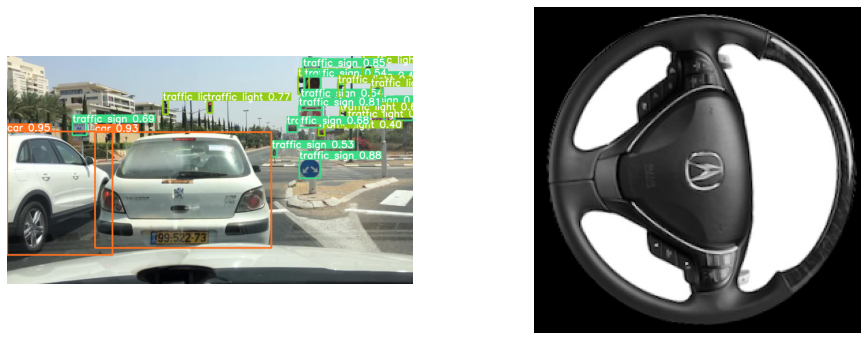

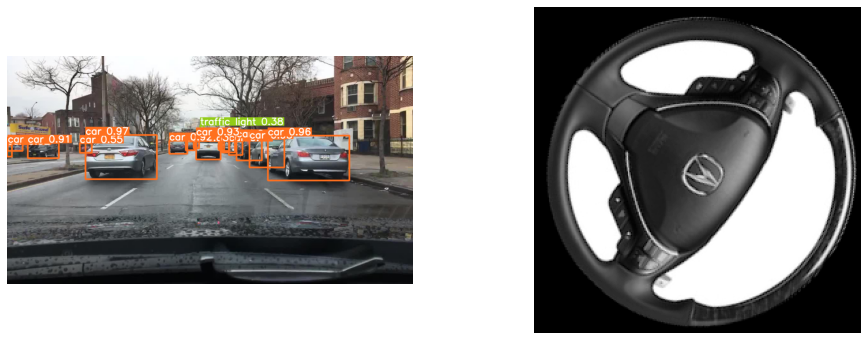

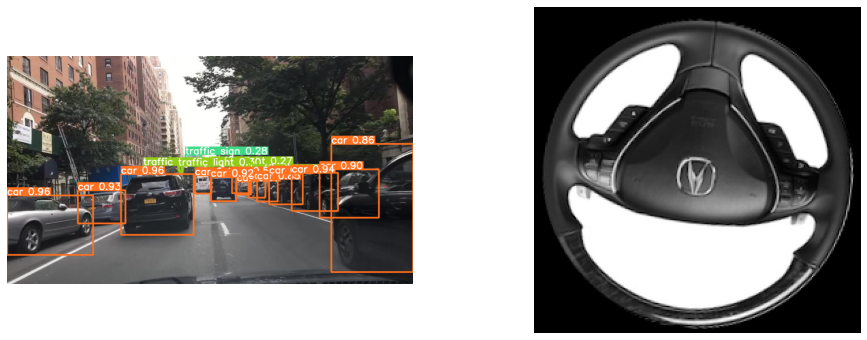

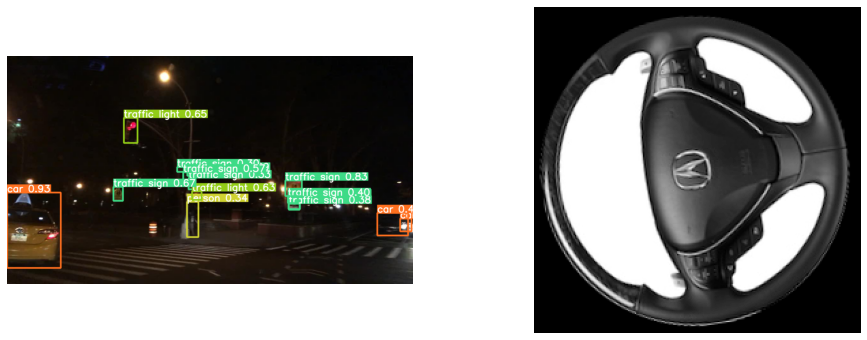

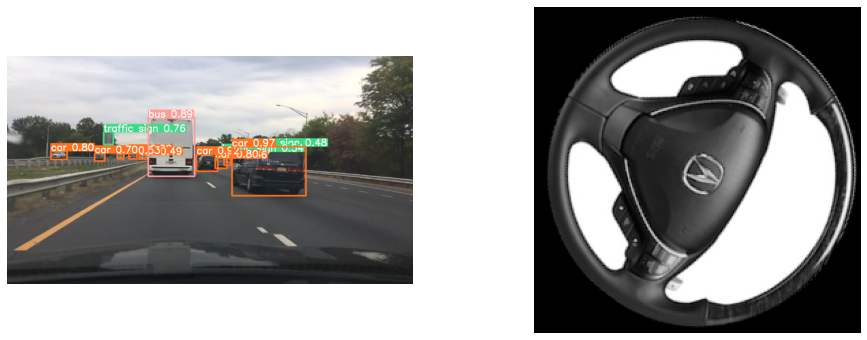

In [14]:
for i in range(5):
    fig, ax = plt.subplots(figsize=(16,6), nrows=1, ncols=2)
    ax[0].axis('off')
    img = cv2.imread(sample_images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    res = model(img)
    ax[0].imshow(np.squeeze(res.render()))
    ax[1].axis('off')
    res_df = pd.concat(res.pandas().xyxy)
    centriod = res_df[['xmin', 'xmax']].mean(axis=1).mean()
    h = (320-centriod)/320
    h = (h+1)*(h)*(h-1)
    rot = h*630
    M = cv2.getRotationMatrix2D((cols/2,rows/2), rot, 1)
    dst = cv2.warpAffine(wheel, M, (cols,rows))
    ax[1].imshow(dst, cmap='gray')
    plt.show()